# Исследование данных Retention

В текущем исследовании рассматриваются данные телекоммуникационной компании по пользователям. Переменная "Сумма ежемесячной платы" и демографические признаки (пол, семейное положение, является ли клиент пожилым гражданином, есть ли дети) респодентов для анализа различий в характеристиках данных параметров.
Таким образом, цель данного исследования - выявить, имеются ли различия в ежемесячной плате в зависимости от демографических признаков пользователей.<br>
Задачи:<br>
    1. Проанализировать датасет в целом, определить характеристики переменных <br>
    2. Провести анализ нормальности для выбора статистического теста <br>
    3. Провести тесты на сравнение средних <br>
    4. Простроить регрессию для определения предсказательной базы переменной оттока <br>

In [111]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import stats
import pingouin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

Считываем csv-файл и загружаем данные в pandas dataframe

In [21]:
retention_data = pd.read_csv('/Users/ekaterinaansina/Downloads/Customer_retention.csv',sep = ',')

Выведем первые 5 строчек dataframe

In [22]:
retention_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Через метод .info() посмотрим основную информацию о датасете

In [23]:
retention_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Таким образом мы видим, что:<br>
- строк в датасете = 7043
- недостояющих значений = 0
- уникальный идентификатор = customerID
- независимых значений = 18
- эндогенная переменная = Churn 
- количество типов данных = 3

Проверим датасет на наличие пропущенных значений 

In [24]:
retention_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Мы видим, что пропущенных значений нет

Используя метод .dtypes посмотрим типы данных по всем столбцам датасета

In [25]:
retention_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

В нашем датасете доминирует тип данных object, большинство переменных – номинальные. <br> Также мы видим, что TotalCharges имеет тип данных object, хотя по данным мы видим, что в этом столбце находится сумарная выплата клиентов, что является числовыми значениями. <br> Связано это с наличием пробелов в данных по этому столбцу, поэтому для дальнейшей работы, используя метод .loc удалим строки с недостающими значениями

In [27]:
retention_data = retention_data.loc[~retention_data['TotalCharges'].str.contains(' ')]
retention_data['TotalCharges'] = retention_data['TotalCharges'].astype(float)
retention_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Узнаем количество уникальных значений по каждому столбцу датасета, используя метод .nunique()

In [28]:
retention_data.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

Теперь мы видим, что в большинстве случаев наша номинальная состоит из 3 значений

Создадим списки, в которые распределим столбцы нашего датасета на текстовые и числовые

In [29]:
text_col = ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
num_col = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Проанализируем распределение значений с помощью гистограмм

(array([2709., 1228.,  671.,  508.,  454.,  412.,  395.,  310.,  223.,
         122.]),
 array([  18.8,  885.4, 1752. , 2618.6, 3485.2, 4351.8, 5218.4, 6085. ,
        6951.6, 7818.2, 8684.8]),
 <BarContainer object of 10 artists>)

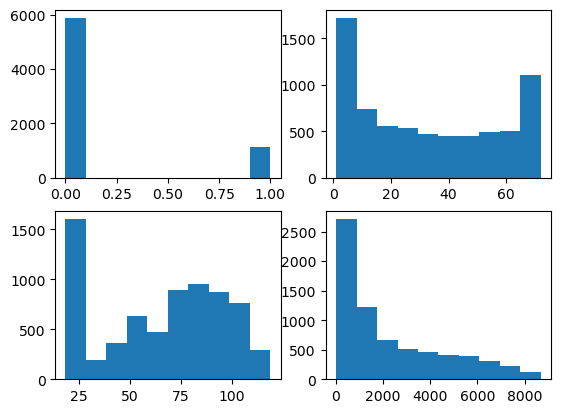

In [30]:
fig, axs = plt.subplots(2, 2)
axs[0][0].hist(retention_data['SeniorCitizen'])
axs[0][1].hist(retention_data['tenure'])
axs[1][0].hist(retention_data['MonthlyCharges'])
axs[1][1].hist(retention_data['TotalCharges'])

В данных графиках мы видим, что они не имеют нормального распределения.<br>
Выводы:<br>
    1. Доминирует молодая ЦА (превышение в 3 раза) <br>
    2. Мы видим, что клиент в основном или сразу прекращал взаимодействие с оператором или оставался долгосрочно.
    3. Большая часть клиентов выбирает тариф за 25 у.е., что является наименьшим значением<br>
    4. Максимальная общая финальная стоимость (LTV) равняется около 8000 у.е. 

Посмотрим отдельно детальнее каждый график, используя библиотеку seaborn и метод .histplot

<Axes: xlabel='tenure', ylabel='Count'>

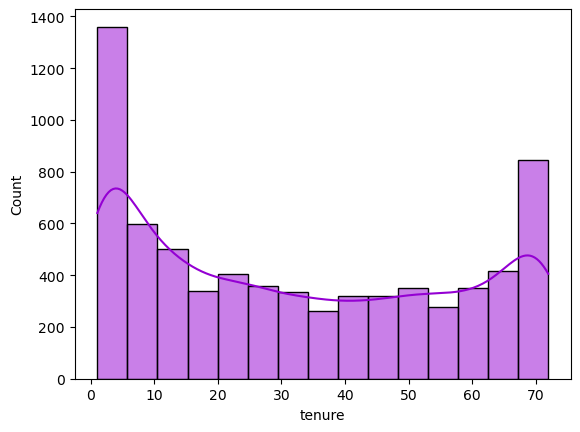

In [84]:
sns.histplot(data=retention_data['tenure'], kde=True, color= 'darkviolet')

Наибольший отток клиентов происходит в первые 5 месяцев

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

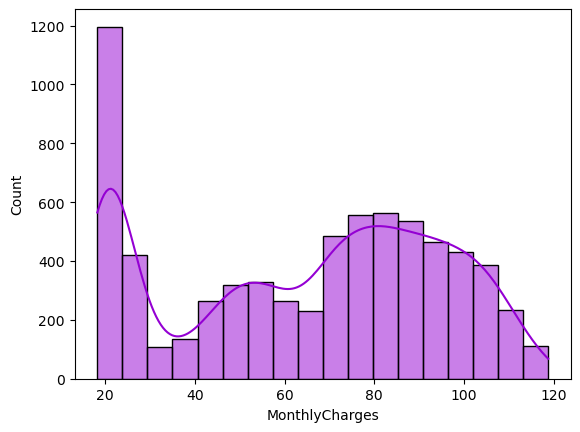

In [85]:
sns.histplot(data=retention_data['MonthlyCharges'], kde=True, color= 'darkviolet')

По гистограмме видно, что наибольшее количество клиентов имеет ежемесячную сумму оплаты 20 у.е. <br>
Небольшое количество клиентов платит от 25 до 65 у.е. и большое количество клиентов платит от 70 до 105 у.е.

<Axes: xlabel='TotalCharges', ylabel='Count'>

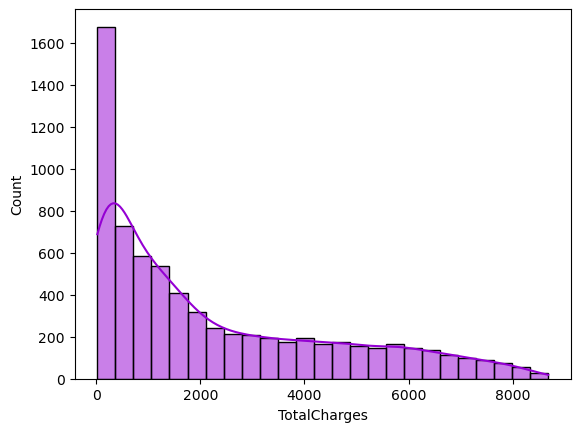

In [31]:
sns.histplot(data=retention_data['TotalCharges'], kde=True, color= 'darkviolet')

TotalCharges напрямую зависит от количества месяцев пользования услугами и учитывая, что по большинству клиентов происходил отток в первые 5 месяцев, на текущей гистограмме мы видим, что большинство клиентов суммарно заплатили до 2000 у.е.

Теперь перейдем к анализу текстовых столбцов

<Axes: xlabel='gender', ylabel='count'>

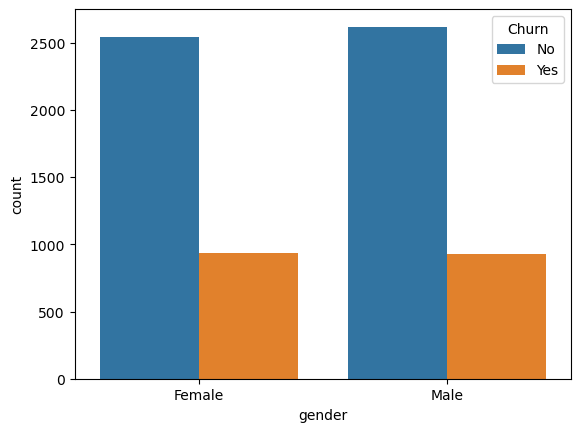

In [34]:
sns.countplot(data=retention_data[text_col], x='gender', hue='Churn')

Мы видим, что нет гендерного различия среди клиентов, которые перестают пользоваться услугами. Однако, среди оставшихся пользователей значимые различия также отсутствуют

<Axes: xlabel='Partner', ylabel='count'>

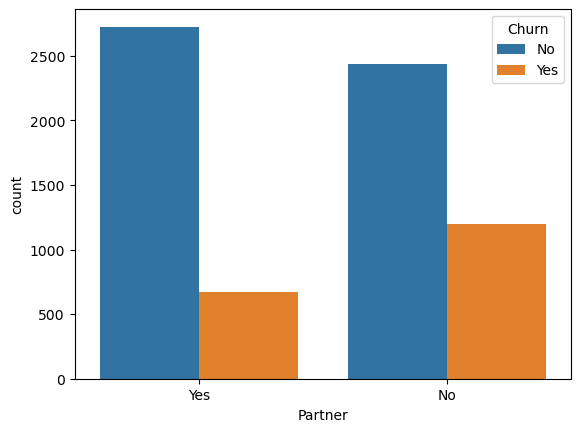

In [35]:
sns.countplot(data=retention_data[text_col], x='Partner', hue='Churn')

Мы видим, что среди клиентов, которые перестали пользоваться услугами, больше одиночек. Однако, среди тех, кто остался, доминируют семейные люди.

<Axes: xlabel='InternetService', ylabel='count'>

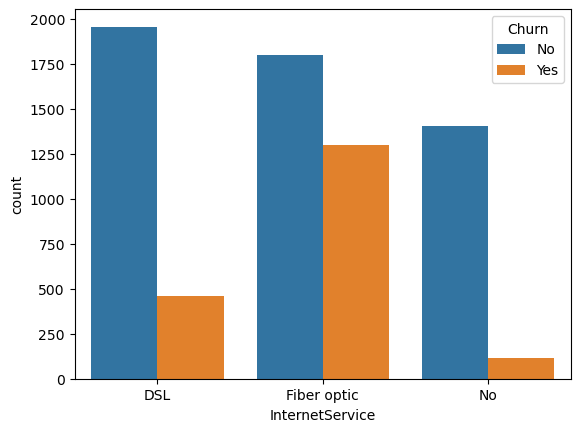

In [36]:
sns.countplot(data=retention_data[text_col], x='InternetService', hue='Churn')

Как видно из графика, среди клиентов, которые отказались от услуг, больше всего клиентов интернет-провайдера Fiber optic InternetService. Однако, среди тех, кто остался, доминирует DSL провайдер.

<Axes: xlabel='Contract', ylabel='count'>

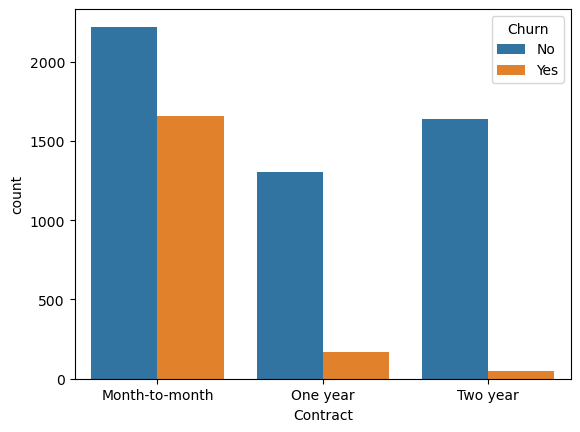

In [37]:
sns.countplot(data=retention_data[text_col], x='Contract', hue='Churn')

Чем дольше срок действия договора, на который соглашается клиент, тем ниже вероятность, что он перестанет пользваться услугами.

In [38]:
retention_data[num_col].describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


В данной таблице представлена описательная статистика. <br>
Из нее мы делаем вывод, что в среднее значение по столбцу tenure – 32, среднее значение по MonthlyCharges – 64.8

Теперь через метод .mode посмотрим моду по числовым столбцам

In [39]:
retention_data[num_col].mode()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,20.05,20.2


Наиболее часто люди пользуются услугами 1 месяц, ежесячно платят 20.05 у.е., общая сумма 20.2

In [40]:
retention_data[num_col].var()

SeniorCitizen     1.360459e-01
tenure            6.024698e+02
MonthlyCharges    9.051658e+02
TotalCharges      5.138252e+06
dtype: float64

Мы видим, что коэффициент вариации незначительный, что говорит нам о том, что наши переменные не обладают сильной изменчивостью

In [41]:
retention_data[num_col].std()

SeniorCitizen        0.368844
tenure              24.545260
MonthlyCharges      30.085974
TotalCharges      2266.771362
dtype: float64

In [42]:
np.sqrt(retention_data[num_col].var())

SeniorCitizen        0.368844
tenure              24.545260
MonthlyCharges      30.085974
TotalCharges      2266.771362
dtype: float64

Величина среднего квадратичного отклонения приведена в строке выше

Теперь проведем z-оценку и проанализируем z-распределение используя библиотеку scipy и метод .zscore который вычисляет z-оценку по каждому значению датафрейма относительно среднего значения и стандартного отклонения <br> Результат запуска программы запишем в новый датафрейм df3

In [46]:
df3 = scipy.stats.zscore(retention_data[num_col], axis=0)
df3

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,-0.440327,-1.280248,-1.161694,-0.994194
1,-0.440327,0.064303,-0.260878,-0.173740
2,-0.440327,-1.239504,-0.363923,-0.959649
3,-0.440327,0.512486,-0.747850,-0.195248
4,-0.440327,-1.239504,0.196178,-0.940457
...,...,...,...,...
7038,-0.440327,-0.343137,0.664868,-0.129180
7039,-0.440327,1.612573,1.276493,2.241056
7040,-0.440327,-0.872808,-1.170004,-0.854514
7041,2.271039,-1.158016,0.319168,-0.872095


Далее посмотрим выбросы по столбцам. Через методы .min и .max посмотрим максимальные положительные и максимальные отрицательные отклонения

In [44]:
print(f"Min: \n{df3.min()} \n \nMax: \n{df3.max()}")

Min: 
SeniorCitizen    -0.440327
tenure           -1.280248
MonthlyCharges   -1.547283
TotalCharges     -0.999069
dtype: float64 
 
Max: 
SeniorCitizen     2.271039
tenure            1.612573
MonthlyCharges    1.793381
TotalCharges      2.824261
dtype: float64


Далее построим корелляционную матрицу используя библиотеку seaborn и метод .heatmap. Через параметр annot=True выводим значения корреляции ячейках матрицы

<Axes: >

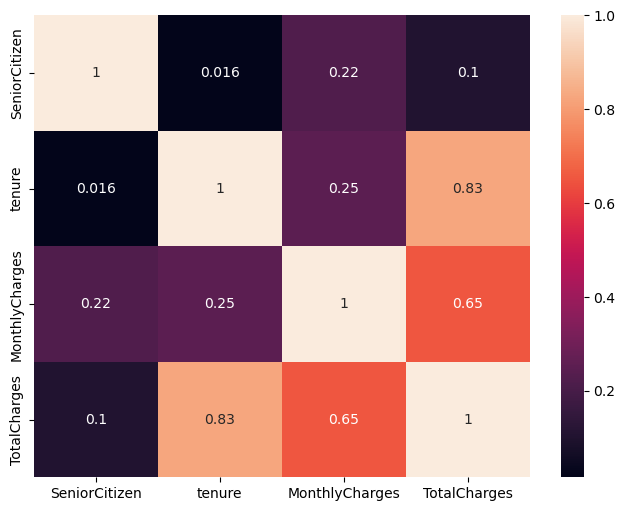

In [50]:
plt.figure(figsize=(8,6))
corr = retention_data[num_col].corr()
sns.heatmap(corr, annot=True)

Сильная коррелиция (>= 0.65) наблюдается между переменными:<br>
1. tenure (количество месяцев, в течение которых клиент оставался) и TotalCharges (общая сумма)<br>
2. MonthlyCharges (сумма, взимаемая с клиента ежемесячно) и и TotalCharges (общая сумма)<br>

Слабая корреляция:<br>
1. SeniorCitizen (является ли клиент пожилым ) и tenure (количество месяцев, в течение которых клиент оставался) <br>
2. SeniorCitizen (является ли клиент пожилым гражданином) и MonthlyCharges (сумма, взимаемая с клиента ежемесячно) <br>
3. SeniorCitizen (является ли клиент пожилым гражданином) и TotalCharges (общая сумма, списанная с клиента) <br>


# Переходим к анализу переменной MonthlyCharges

Для того, чтобы понять, какой необходимо использовать тест для проведения сравнения средних необходимо провести анализ на нормальное распределение

В начале посмотрим на гистрограмму

64.79820819112628

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


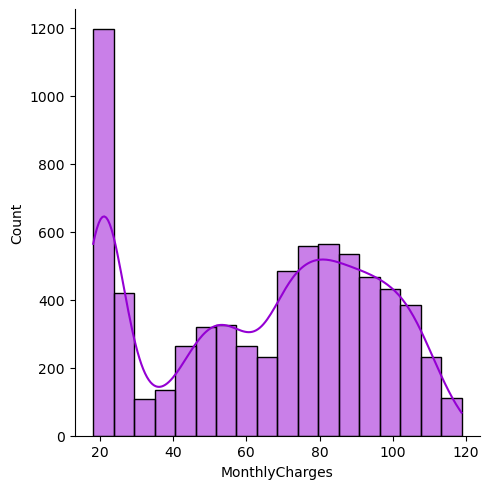

In [55]:
display(retention_data['MonthlyCharges'].mean())
sns.displot(x='MonthlyCharges', data=retention_data, kde=True, color= 'darkviolet')

Распределение визуально говорит что оно "ненормальное", так как много значений около 20

Теперь проверим нормальное распределение с помощью теста Шапиро-Уилка <br>
Но: переменная имеет нормальное распределение <br>
На: переменная имеет не нормальное распределение <br>

За значение alpha берем 5%. 
Для проверки теста создаем функцию, которая будет проводить тестирование гипотезы на основе вводных данных

In [74]:
def normality_test(data, metric):
    p_value_shapiro = stats.shapiro(data[metric])[1]
    display(p_value_shapiro)
    if p_value_shapiro <= 0.05:
        print("Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.")
    else:
        print("Принимаем основную гипотезу, так как p-value >= 0,05.")

In [75]:
normality_test(retention_data,'MonthlyCharges')

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


Наша переменная не имеет нормальное распределение, поэтому нам необходимо использовать непараметрический тест для оценки средних значений

Теперь построим визуализацию среднего чека в месяц (Monthly Charges), разделяя по переменной gender, SeniorCitizen, partner, Dependents <br>
Чтобы найти предпосылки для теста гипотезы о разнице среднего чека среди определенных выборок.

________

Начнем с анализа разницы среднего чека в месяц (Monthly Charges) между Женщинами и Мужчинами

Также задаем функцию для построения визуализации и определения среднего значения по выборкам

In [76]:
def mean_boxplot(data, sample, metric):
    display(data.groupby(sample)[metric].mean())
    sns.catplot(x=sample,
            y=metric,
            data=data,
            kind='box')
    plt.show()

gender
Female    65.216652
Male      64.387546
Name: MonthlyCharges, dtype: float64

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


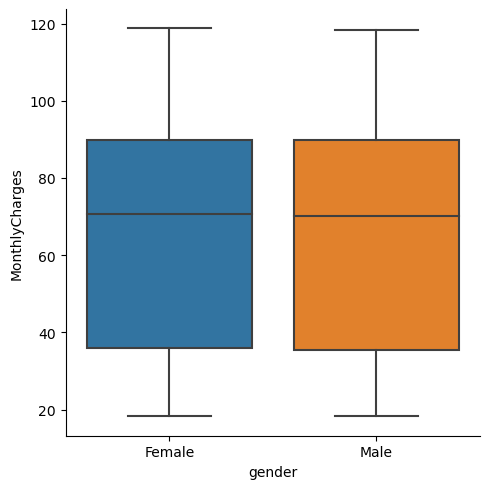

In [77]:
mean_boxplot(retention_data, 'gender', 'MonthlyCharges')

Средний чек женщин = 65.2<br>
Средний чек мужчин = 64.3 <br>
Исходя из средних значений мы не можем заявлять о наличии взаимосвязи между средним чеком и гендером.

Используя Шапиро-Уилка тест, определим "нормальность" распределения для мужчин <br>
Но: переменная имеет нормальное распределение <br>
На: переменная имеет не нормальное распределение <br>

In [78]:
retention_data_male = retention_data[retention_data['gender'] == 'Male']
normality_test(retention_data_male,'MonthlyCharges')

8.241414619279617e-40

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


Наша переменная имеет нормальное распределение

Используя Шапиро-Уилка тест, определим "нормальность" распределения для женщин <br>
Но: переменная имеет нормальное распределение <br>
На: переменная имеет не нормальное распределение <br>

In [79]:
retention_data_female = retention_data[retention_data['gender'] == 'Female']
normality_test(retention_data_female,'MonthlyCharges')

2.631014938185382e-39

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


Наша переменная имеет нормальное распределение

Таким образом, мы видим, что в обоих выборках - распределение ненормальное <br>
Следовательно, для теста гипотезы разницы среднего чека Женщин и Мужчин нужно использовать непараметрический тест - Mann-Whitney U, как альтернатива параметрических two-sample test.

Используем библиотеку pingouin, которая нужна для определения функции для преобразования данных в нужный формат и проведем MWU test, а за значение alpha возьмем 10%


In [80]:
def mwu_full(data, sample, type1, type2, metric, alternative):
    data_wide = data[[sample, metric]].pivot(columns=sample, values=metric)
    test_results = pingouin.mwu(x=data_wide[type1],
                                y=data_wide[type2],
                                alternative=alternative)
    p = test_results['p-val'].values[0]
    if p <= 0.1:
        result = 'Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,1'
    else:
        result = 'Принимаем основную гипотезу, так как p-value >= 0,1'
    result_dict = {'p_val' : p, 'результат' : result}
    print(result_dict)

In [81]:
mwu_full(retention_data, 'gender', 'Female', 'Male', 'MonthlyCharges', 'greater')

{'p_val': 0.13628636951957862, 'результат': 'Принимаем основную гипотезу, так как p-value >= 0,1'}


Вывод теста гипотезы разницы среднего значения среднего чека между Мужчинами и Женщинами: <br>
Хотя и среднее значение после расчета показали, что значения для Женщин = 65.20, а Мужчин = 64.32. Тест MWU показал, что эта разница не является статистически значимой.

______

Теперь проведём такой же анализ между пожилыми и непожилыми людьми

SeniorCitizen
0    61.885594
1    79.820359
Name: MonthlyCharges, dtype: float64

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


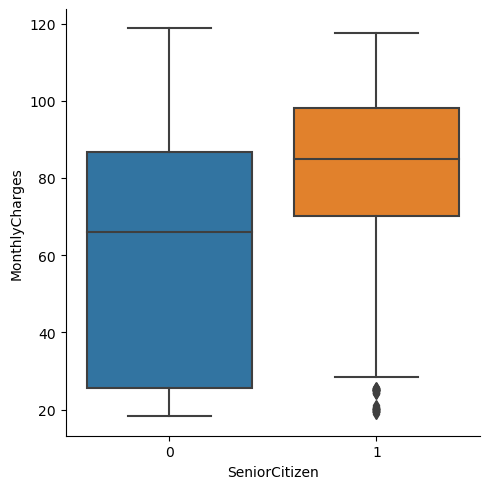

In [82]:
mean_boxplot(retention_data, 'SeniorCitizen', 'MonthlyCharges')

Ежемесячная плата пожилых людей = 79.82<br>
Ежемесячная плата  непожилых людей = 61.84

Также проведем тест Шапиро-Уилка на нормальность распределения Пожилых и Не пожилых клиентов <br>
Но: переменная имеет нормальное распределение <br>
На: переменная имеет не нормальное распределение <br>

In [83]:
retention_data_senior = retention_data[retention_data['SeniorCitizen'] == 1]
normality_test(retention_data_senior,'MonthlyCharges')

4.3824059239981475e-24

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


In [84]:
retention_data_senior = retention_data[retention_data['SeniorCitizen'] == 0]
normality_test(retention_data_senior,'MonthlyCharges')

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


Таким образом, мы видим, что в обоих выборках распределение ненормальное <br>
Следовательно, для теста гипотезы разницы среднего чека пожилых и не пожилых людей нужно использовать непараметрический тест - Mann-Whitney U.

In [85]:
mwu_full(retention_data, 'SeniorCitizen', 1, 0, 'MonthlyCharges', 'greater')

{'p_val': 8.728929616456962e-77, 'результат': 'Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,1'}


MWU тест показал, что пожилые люди в среднем имеют больший средник чек (Monthly Charge) в отличии от не пожилых, разница имеет статистическую значимость

___

Проведем тест анализа с переменной Partner

Partner
No     61.956472
Yes    67.845977
Name: MonthlyCharges, dtype: float64

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


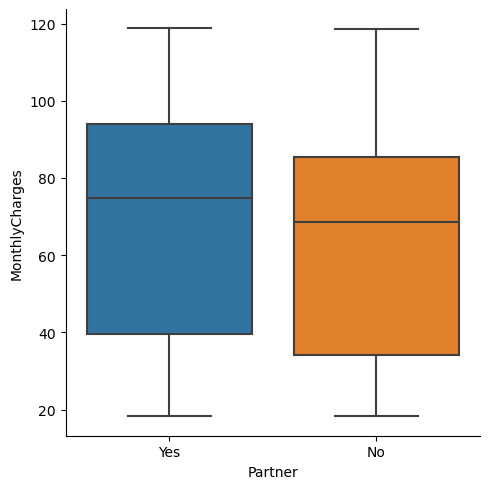

In [86]:
mean_boxplot(retention_data, 'Partner', 'MonthlyCharges')

Ежемесячная плата людей с партнером = 67.845977 <br>
Ежемесячная плата людей без партнера = 61.956472 <br>

Для проверки нормальности проведем тест Шапиро-Уилка для двух подвыборок <br>
Но: переменная имеет нормальное распределение <br>
На: переменная имеет не нормальное распределение <br>

In [87]:
retention_data_part = retention_data[retention_data['Partner'] == 'Yes']
normality_test(retention_data_part,'MonthlyCharges')

6.825724819726184e-41

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


In [88]:
retention_data_part = retention_data[retention_data['Partner'] == 'No']
normality_test(retention_data_part,'MonthlyCharges')

6.67441261154839e-39

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


Таким образом, в обоих выборках - распределение ненормальное <br>
Следовательно, для теста гипотезы разницы среднего чека людей c партнером и без нужно использовать непараметрический тест - Mann-Whitney U.

In [89]:
mwu_full(retention_data, 'Partner', 'Yes', 'No', 'MonthlyCharges', 'greater')

{'p_val': 2.196744011224655e-20, 'результат': 'Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,1'}


MWU тест показал, что люди живущие с партнером в среднем имеют больший средний чек (Monthly Charge) в отличии от тех, кто живет без партнера. <br> Разница не имеет статистическую значимость

___

Наконец, проведем аналогичный тест для переменной Dependents - есть ли у клиента дети, пожилые родители

Для проверки нормальности проведем тест Шапиро-Уилка для двух подвыборок<br>
Но: переменная имеет нормальное распределение <br>
На: переменная имеет не нормальное распределение <br>

Dependents
No     67.002808
Yes    59.617032
Name: MonthlyCharges, dtype: float64

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


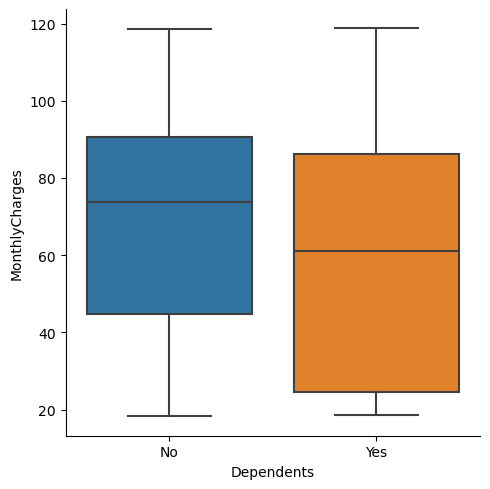

In [90]:
mean_boxplot(retention_data, 'Dependents', 'MonthlyCharges')

Ежемесячная плата людей без детей, пожилых родителей = 67<br>
Ежемесячная людей с детьми, пожилыми родителями = 59.6<br>

In [91]:
retention_data_part = retention_data[retention_data['Dependents'] == 'Yes']
normality_test(retention_data_part,'MonthlyCharges')

1.7728128512317575e-34

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


In [92]:
retention_data_part = retention_data[retention_data['Dependents'] == 'No']
normality_test(retention_data_part,'MonthlyCharges')

5.885453550164232e-44

Отклоняем основную гипотезу и принимаем альтернативную, так как p-value <= 0,05.


Таким образом, в обоих выборках - распределение ненормальное <br>
Следовательно, для теста гипотезы разницы ежемесячной платы людей c партнером и без нужно использовать непараметрический тест - Mann-Whitney U.

In [93]:
mwu_full(retention_data, 'Dependents', 'Yes', 'No', 'MonthlyCharges', 'greater')

{'p_val': 1.0, 'результат': 'Принимаем основную гипотезу, так как p-value >= 0,1'}


MWU тест показал, что люди живущие с детьми и родителями и без различаются в ежемесячном плате (Monthly Charge) . <br> Разница имеет статистическую значимость

# Построим модель, предсказывающую зависимую переменную Churn, на основе логистической регрессии

Так как Churn является номинальной (биномиальной) переменной, принимающей два значения Да и Нет,необходимо использовать именно логистическую регрессию.

Для построения модели все переменные должны быть количественными, поэтому на следующих этапах мы преобразуем некоторые переменные в количественные типы данных.

Выделяем в датасете идентификатор и зависимую переменную

In [95]:
custID = ['customerID']
target = ['Churn']

Выделяем качественные переменные из всех

In [96]:
categorical = retention_data.nunique()[retention_data.nunique() < 5].keys().tolist()
categorical.remove(target[0])

Выделяем количественные переменные

In [97]:
numerical = [col for col in retention_data.columns
                if col not in custID + target + categorical]
numerical

['tenure', 'MonthlyCharges', 'TotalCharges']

Преобразуем качественные переменные в количественные с помощью метода one-hot encoding

In [104]:
one_hot_retention_data = pd.get_dummies(data=retention_data, columns = categorical, drop_first=True)

Теперь стаднартизируем остальные количественные переменные, для того, чтобы никакие переменные не "перевешивали" при тренировке модели

In [105]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(retention_data[numerical])
scaled_numerical = pd.DataFrame(scaled_numerical, columns = numerical)

Из изначального датасета убираем не стандартизированные количественные переменные и объединяем всё в готовый датасет

In [106]:
retention_data_dummy = one_hot_retention_data.drop(columns=numerical, axis=1)

retention_ready = retention_data_dummy.merge(right=scaled_numerical,
                                        how='left',
                                        left_index=True,
                                        right_index=True)

In [107]:
retention_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7032 non-null   object 
 1   Churn                                  7032 non-null   object 
 2   gender_Male                            7032 non-null   bool   
 3   SeniorCitizen_1                        7032 non-null   bool   
 4   Partner_Yes                            7032 non-null   bool   
 5   Dependents_Yes                         7032 non-null   bool   
 6   PhoneService_Yes                       7032 non-null   bool   
 7   MultipleLines_No phone service         7032 non-null   bool   
 8   MultipleLines_Yes                      7032 non-null   bool   
 9   InternetService_Fiber optic            7032 non-null   bool   
 10  InternetService_No                     7032 non-null   bool   
 11  OnlineSec

Теперь мы видим, что наши переменные имеют количественную характеристику, принимая значения 1 и 0, то есть присутствует ли данный параметр или нет

Мы видим, что переменная TotalCharges содержит недостающие значения (7032 и 7021). Для точности - удалим строки с недостающими значениями.

In [108]:
retention_ready = retention_ready.dropna()

Разделим датасет на тренировочный и тестовый срезы. Определяем размер тестового среза на 25% от изначального.

In [110]:
train, test = train_test_split(retention_ready, test_size = .25)
cols = [col for col in retention_ready.columns if col not in custID + target]
train_X = train[cols]
train_Y = train[target]
test_X = test[cols]
test_Y = test[target]

Импортируем модель и инициализируем модель

In [112]:
logreg = LogisticRegression()

Теперь обучим нашу модель

In [113]:
logreg.fit(train_X, train_Y)

/Users/ekaterinaansina/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Проведем тест модели и оценим точность

In [115]:
pred_train_Y = logreg.predict(train_X)
pred_test_Y = logreg.predict(test_X)
train_accuracy = accuracy_score(train_Y, pred_train_Y)
test_accuracy = accuracy_score(test_Y, pred_test_Y)
print('Accuracy по train выборке:', round(train_accuracy, 3))
print('Accuracy по test выборке:', round(test_accuracy, 3))

Accuracy по train выборке: 0.793
Accuracy по test выборке: 0.776


Получившаяся модель корректно предсказывает 80% всех Churn и Non-churn результатов, что является хорошим показателем.<br>
Считаем, что более высокий показатель свидетельствовал бы о проблеме over-fitting, которая бы привела к плохой воспроизводимости с реальными данными. Оver-fitting явление, когда построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки)

Таким образом, мы выявили следующие зависимости:
1. Чем больше клиент потратил на услугу, тем дольше он будет пользоваться ей
2. Чем больше человек платит в месяц, тем больше его суммарный LTV
3. У людей с партнером меньше отток по сравнению с людьми без партнера